In [14]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

import prepare as prep
import acquire as get

1. Split store data (train/validate/test) and resample by any period except daily. Aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.

In [15]:
df = get.get_store_item_demand_data()

Using cached CSV


In [16]:
df.columns

Index(['sale_id', 'store_id', 'item_id', 'item_brand', 'item_name',
       'item_price', 'sale_amount', 'sale_date', 'store_address', 'store_city',
       'store_state', 'store_zipcode', 'item_upc12', 'item_upc14'],
      dtype='object')

In [17]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

# Drop the leap-year
df = df[df.index != '2016-02-29']

In [18]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]


In [19]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [7]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [8]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [20]:
items = train['items_sold'][-1:][0]
dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2


In [21]:
items = train['items_sold'][-1:][0]
dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2


In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [25]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


In [26]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)


yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)

yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,23717.94,127517.85
2015-07-03 00:00:00+00:00,23717.94,127517.85
2015-07-04 00:00:00+00:00,23717.94,127517.85


dollars_sold -- RMSE: 39664


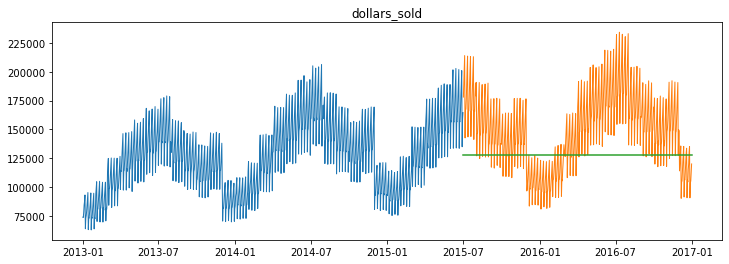

items_sold -- RMSE: 7378


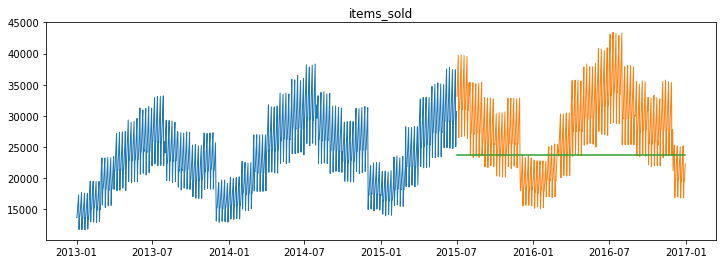

In [27]:
for col in train.columns:
    plot_and_eval(col)

In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


In [29]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31432.77,168957.91
2015-07-03 00:00:00+00:00,31432.77,168957.91


dollars_sold -- RMSE: 37378


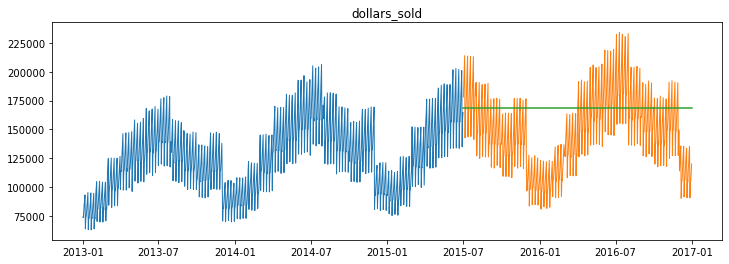

items_sold -- RMSE: 6954


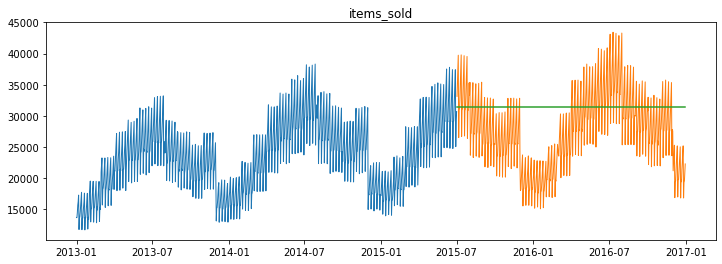

In [30]:
for col in train.columns:
    plot_and_eval(col)

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0


In [32]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)

    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)

    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [33]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


dollars_sold 



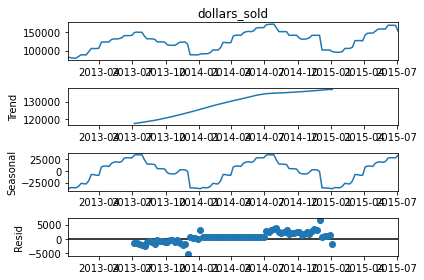

items_sold 



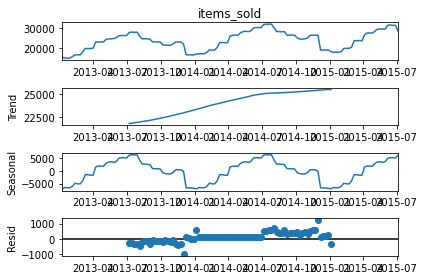

In [34]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

In [35]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


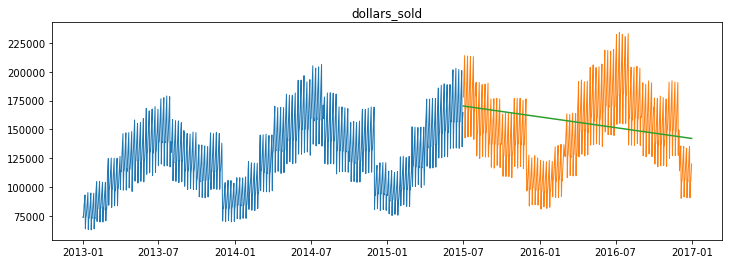

items_sold -- RMSE: 6464


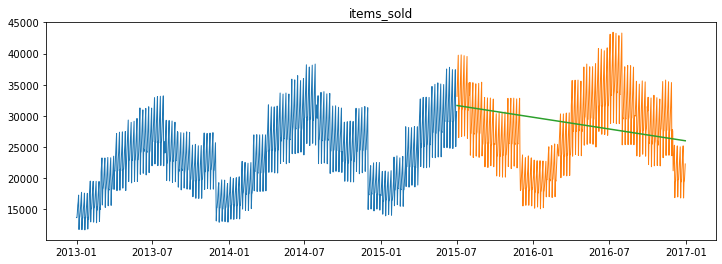

In [36]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
...,...,...,...
15,52d moving average,dollars_sold,35322.0
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0
18,Holts,dollars_sold,34700.0


In [38]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [39]:
yhat_df = train['2015'] + train.diff(365).mean()

In [40]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

365

dollars_sold -- RMSE: 28087


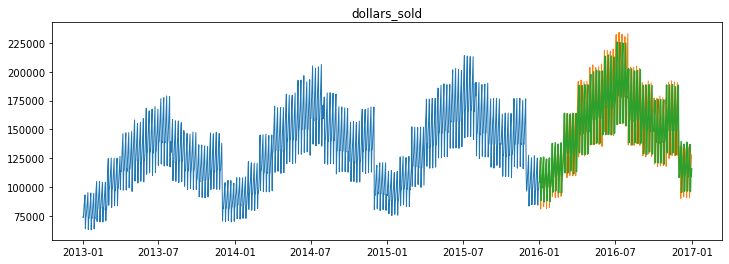

items_sold -- RMSE: 5223


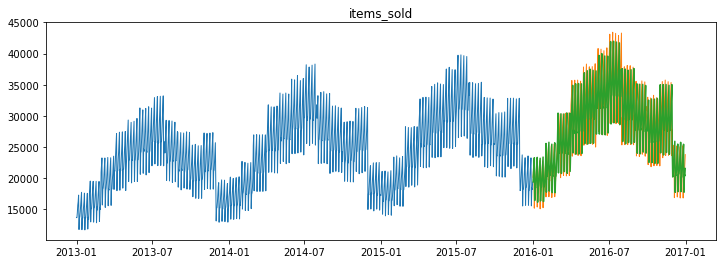

In [41]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [42]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
20,previous year,dollars_sold,28087.0
21,previous year,items_sold,5223.0


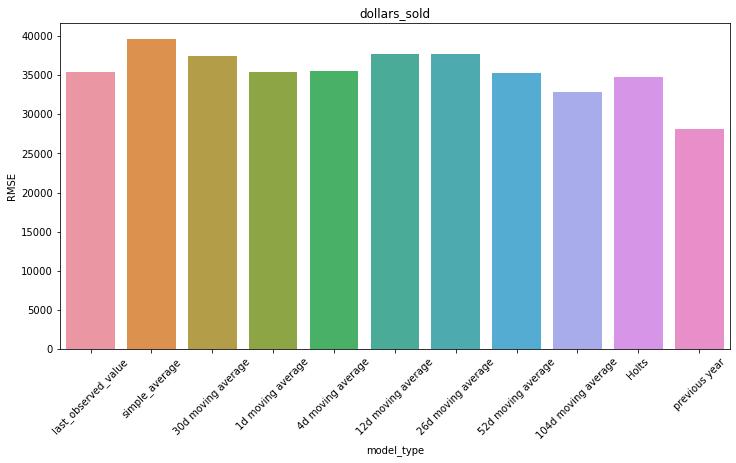

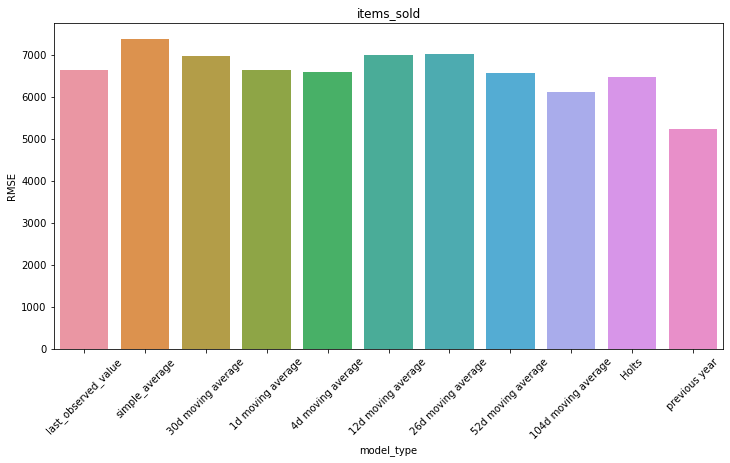

In [43]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [44]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [45]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold'])), 0)


In [46]:
# Plot and evaluate train, validate, and test
def plot_and_eval_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, color="red")
    plt.title(target_var)
    plt.legend()
    plt.show()


rmse - dollars_sold:  27115.0
rmse - items_sold:  5041.0


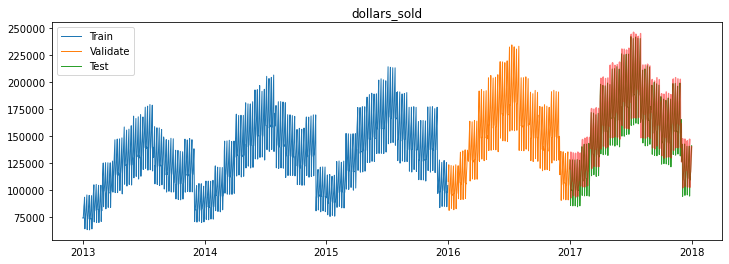

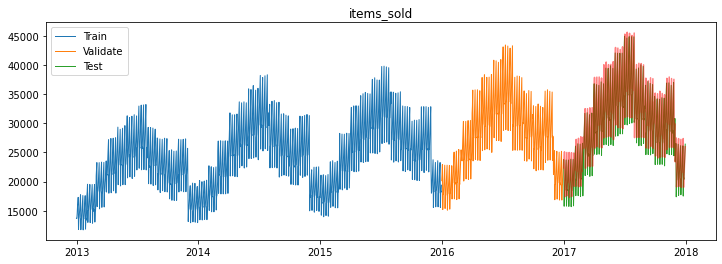

In [47]:
print("rmse - dollars_sold: ", rmse_dollars)
print("rmse - items_sold: ", rmse_items)

for col in train.columns:
    plot_and_eval_test(col)
